## Learning and supervised classification of boat types according to their trajectories and speeds transmitted by AIS messages

### Exploratory analysis
The data is stored in netCDF format 

Documentation for the netCDF4 library https://unidata.github.io/netcdf4-python/


In [1]:
import netCDF4 as nc

In [2]:
ds = nc.Dataset('EXE_20200101_000000_86400_afs_pos.nc')

In [3]:
# Content of the netCDF file"
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    created: clement Le Goff
    company: eodyn.com
    dimensions(sizes): mmsi(243), position(37219), nst(1)
    variables(dimensions): int32 mmsi(mmsi), float64 time(mmsi, position), float64 lon(mmsi, position), float64 lat(mmsi, position), float64 cog(mmsi, position), float64 sog(mmsi, position), float64 trh(mmsi, position), float64 type(mmsi), float64 dimension(mmsi), float64 length(mmsi), float64 width(mmsi), float64 draught(mmsi)
    groups: 


In [4]:
# Author and company of the file
print(ds.__dict__)

{'created': 'clement Le Goff', 'company': 'eodyn.com'}


In [5]:
# Dimensions of the file
# netCDF defines the sizes of all variables in terms of dimensions, 
# so before any variables can be created the dimensions they use must be created first. 
ds.dimensions

{'mmsi': <class 'netCDF4._netCDF4.Dimension'>: name = 'mmsi', size = 243,
 'position': <class 'netCDF4._netCDF4.Dimension'>: name = 'position', size = 37219,
 'nst': <class 'netCDF4._netCDF4.Dimension'>: name = 'nst', size = 1}

### Available variables and their descriptions

In [6]:
for dic in ds.variables.keys():
    print(dic + ": "+ ds.variables[dic].long_name) 
    print("Dimension: " + ' - '.join(ds.variables[dic].dimensions).replace("mmsi", "243").replace("position", "37219"))
    print("")

mmsi: maritime mobile service identity
Dimension: 243

time: time
Dimension: 243 - 37219

lon: longitude
Dimension: 243 - 37219

lat: nodal latitude
Dimension: 243 - 37219

cog: course over ground
Dimension: 243 - 37219

sog: speed over ground
Dimension: 243 - 37219

trh: true heading
Dimension: 243 - 37219

type: type of ship and cargo type
Dimension: 243

dimension: ship dimensions
Dimension: 243

length: ship length
Dimension: 243

width: ship width
Dimension: 243

draught: ship draught
Dimension: 243



- mmsi: maritime mobile service identity
    - User ID
- cog: course over ground
    - Course Over Ground is the actual direction of progress of a vessel, between two points, with respect to the surface of the earth.
- sog: speed over ground
    - Speed Over the Ground (SOG) is the speed of the vessel relative to the surface of the earth. Speed Through Water (STW) is the speed of the vessel relative to the water. It is possible for the STW to be zero while the SOG is 5 knots, for example if the boat was drifting in a 5 knot current.
- trh: true heading
    - True heading is your direction relative to true north, or the geographic north pole. The difference is due to the magnetic north pole and geographic north pole being hundreds of miles apart.
- draught: ship draught 
    - The draft or draught of a ship's hull is the vertical distance between the waterline and the bottom of the hull (keel). Draft determines the minimum depth of water a ship or boat can safely navigate.




### Trajectory visualizations

In [7]:
# Installation of plot libraries
#!conda install -c anaconda basemap -y
#!conda install -c conda-forge basemap-data-hires -y 
#!conda install -c conda-forge geopy -y
#!conda install tqdm -y

In [8]:
import os
os.environ['PROJ_LIB'] = '/home/emilio/anaconda3/envs/fml/share/proj'

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [9]:
# This is to center the map around the data
ind_36 = [i for i in range(len(ds.variables["type"][:].data)) if ds.variables["type"][:].data[i]==36]
ind_30 = [i for i in range(len(ds.variables["type"][:].data)) if ds.variables["type"][:].data[i]==30]

lon_30 = ds.variables["lon"][ind_30]
lat_30 = ds.variables["lat"][ind_30]

lon_0 = lon_30.mean()
lat_0 = lat_30.mean()

m = Basemap(width=5000000*(1/3),height=3500000*(1/3),
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

In [10]:
type_boat = ds.variables['type'][:]
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
x,y = m(lon,lat)

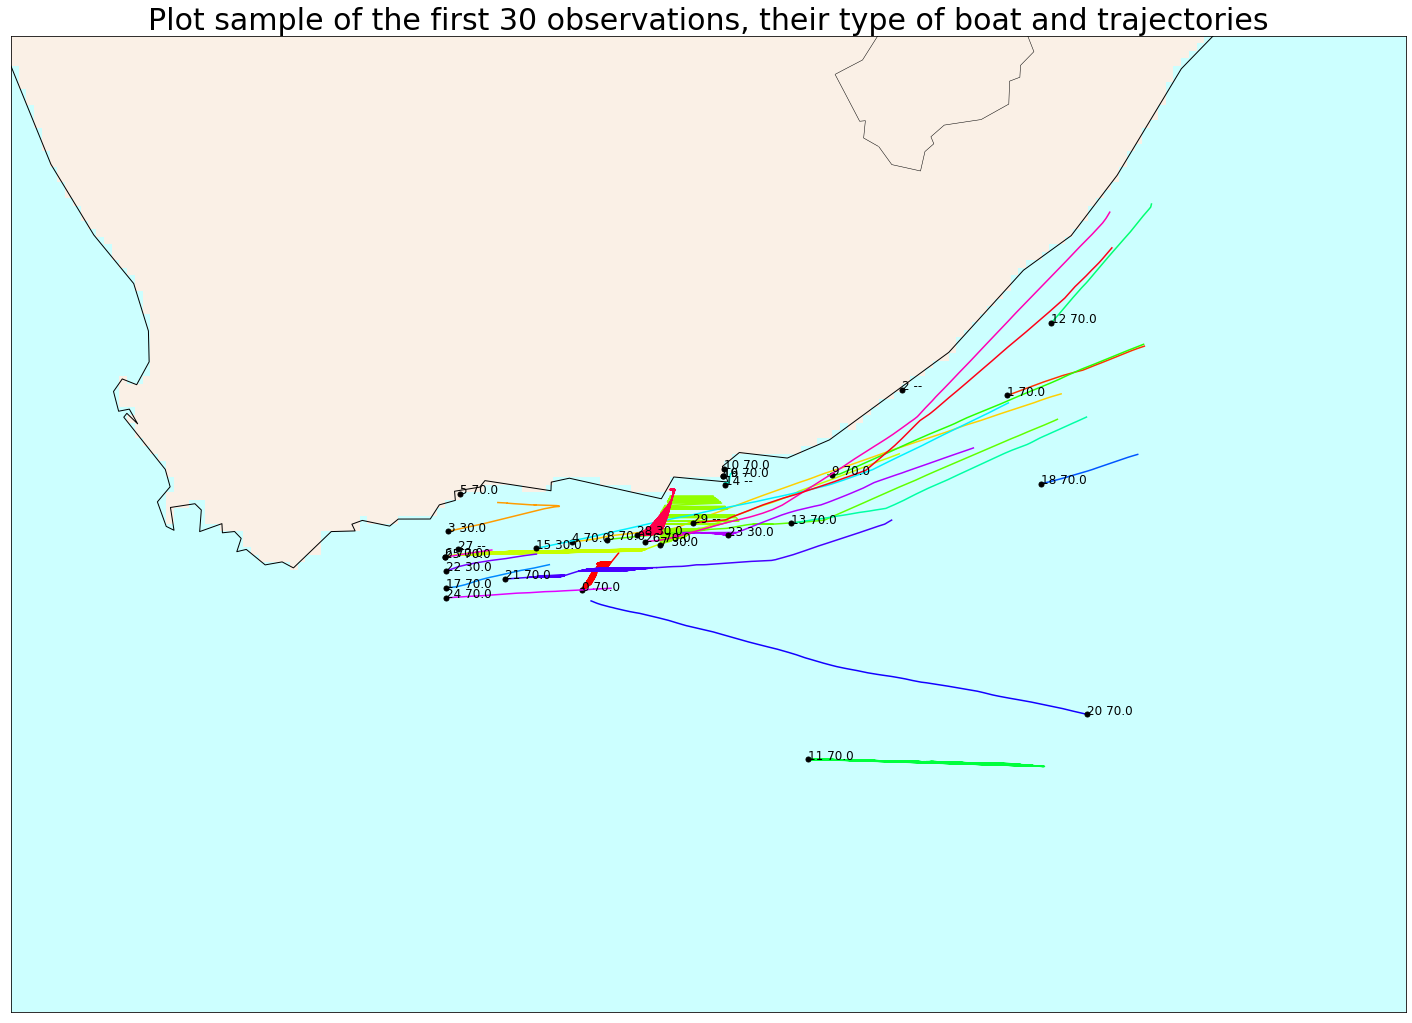

In [11]:
fig = plt.figure(figsize=(25, 20))
plt.title('Plot sample of the first 30 observations, their type of boat and trajectories', fontsize=30)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
m.drawcounties()

array_id_boats = range(30)
cmap = plt.cm.get_cmap('hsv', len(array_id_boats))
for id_ in array_id_boats:
    m.plot(x[id_], y[id_], color=cmap(id_))
    plt.plot(x[id_][0], y[id_][0], 'ok', markersize=5)
    plt.text(x[id_][0], y[id_][0], str(id_) + ' ' + str(type_boat[id_]), fontsize=12)

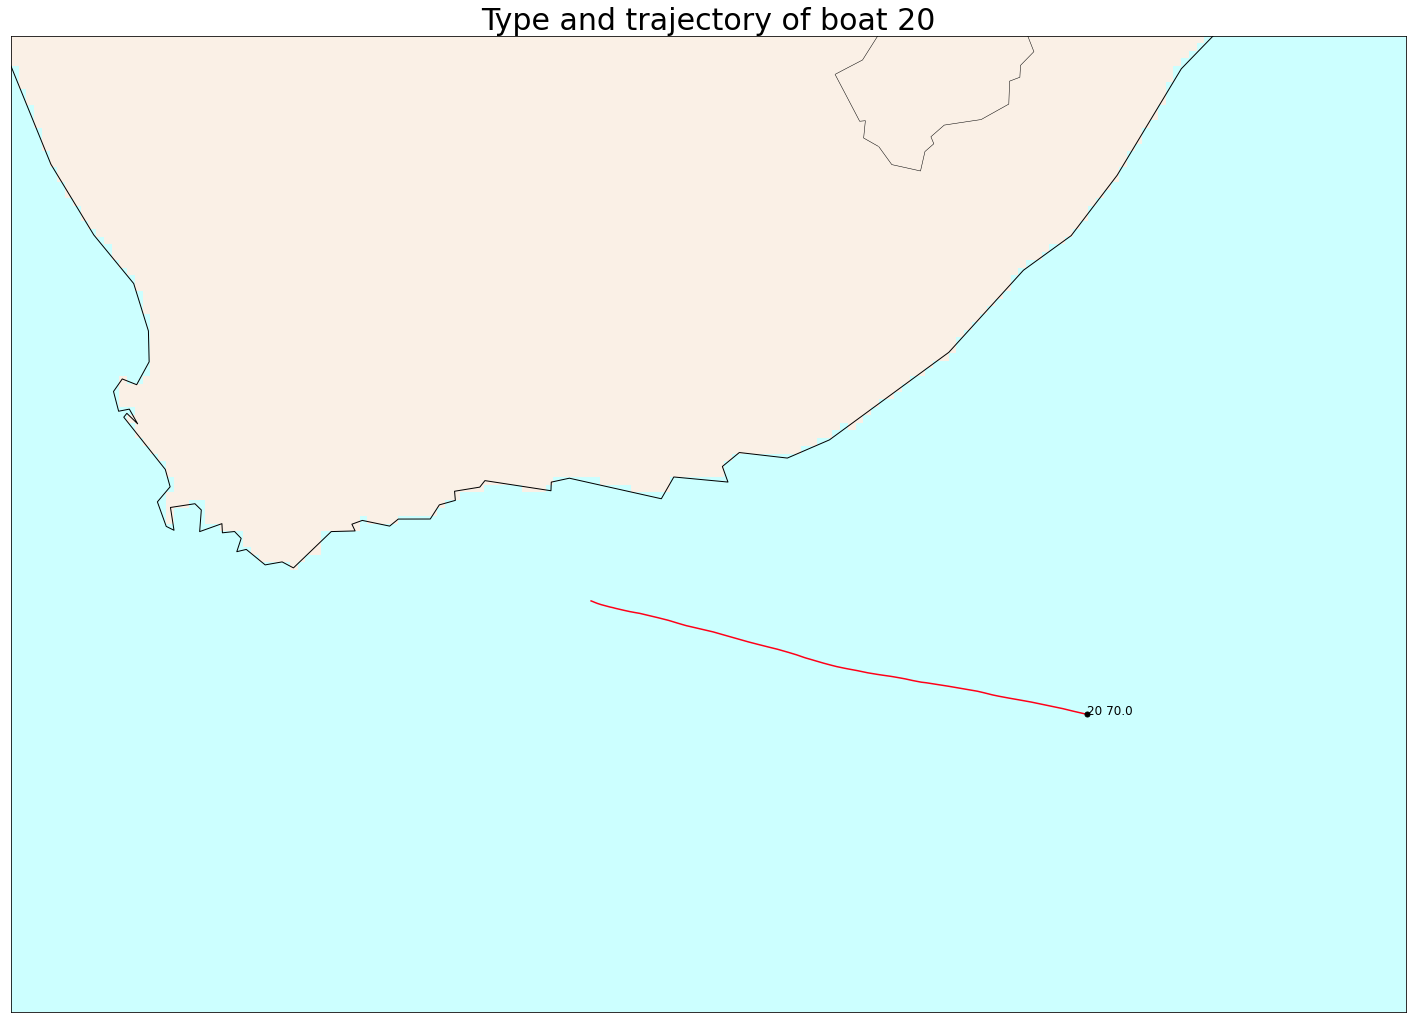

In [12]:
fig = plt.figure(figsize=(25, 20))
plt.title('Type and trajectory of boat 20', fontsize=30)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') # can use HTML names or codes for colors
m.drawcounties()

array_id_boats = [20]
cmap = plt.cm.get_cmap('hsv', len(array_id_boats))
for id_ in array_id_boats:
    m.plot(x[id_], y[id_], color=cmap(id_))
    plt.plot(x[id_][0], y[id_][0], 'ok', markersize=5)
    plt.text(x[id_][0], y[id_][0], str(id_) + ' ' + str(type_boat[id_]), fontsize=12)

The first step would be to filter the boats that didn't move during the whole day.

In [13]:
from geopy import distance
import numpy as np
from tqdm import tqdm

The idea of the cell below it to get the distance between lat and lon observations and sum it up in order to get the travelled distance. We also get the number of non-masked elements by each lat_lon tuple 

In [14]:
distance_array = []
non_masked_values_lat_lon = []
# It takes a lot of processing power
for id_boat in tqdm(range(len(lat.data))):
    lat_lon = list(zip(np.array(lat[id_boat].data[~lat[id_boat].mask]), np.array(lon[id_boat].data[~lon[id_boat].mask])))
    lat_lon_cp = lat_lon.copy()
    
    lat_lon.pop()
    lat_lon_cp.pop(0)
    
    total_distance = sum(list(map(lambda x, y: distance.distance(x, y).km, lat_lon, lat_lon_cp)))
    distance_array.append(total_distance)
    non_masked_values_lat_lon.append(len(lat_lon))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:43<00:00,  5.59it/s]


Text(0.5, 1.0, 'Travelled distance by boat (km)')

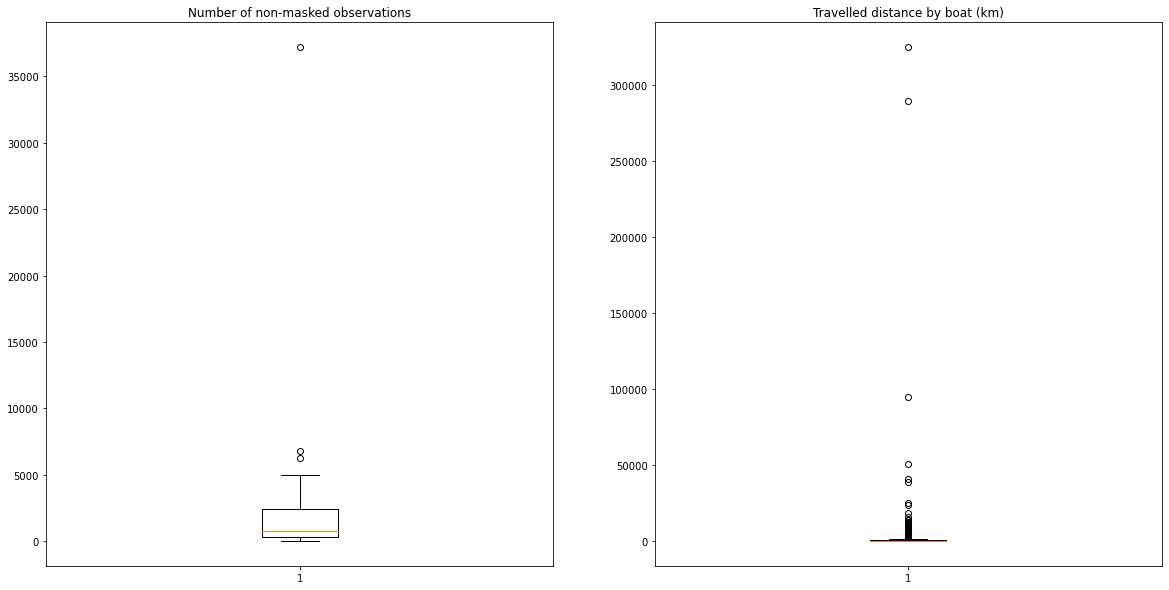

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].boxplot(non_masked_values_lat_lon)
axs[0].set_title('Number of non-masked observations')
axs[1].boxplot(distance_array)
axs[1].set_title('Travelled distance by boat (km)')

We use these indexes to remove some observations

In [16]:
# Boats that traveled more than 50000 km
index_superior_distance = np.where(np.array(distance_array) > 50000)

# Boats that traveled less than 10 km
index_inferior_distance = np.where(np.array(distance_array) < 10)

# Boats that have more than 5000 observations
index_masked_values = np.where(np.array(non_masked_values_lat_lon) > 5000)

# Boats that don't have a class
index_no_class = np.where(np.array(type_boat.data == 0))

index_to_remove = np.unique(np.concatenate((index_superior_distance[0], 
                                            index_inferior_distance[0], 
                                            index_masked_values[0],
                                            index_no_class[0]
                                           ), axis=None))

In [17]:
index_to_remove

array([  2,   5,  10,  14,  16,  19,  27,  29,  33,  34,  35,  54,  55,
        57,  60,  63,  68,  71,  72,  75,  78,  81,  84,  91,  95, 103,
       104, 108, 111, 114, 115, 118, 124, 129, 133, 135, 136, 137, 138,
       145, 150, 152, 162, 166, 171, 172, 173, 174, 177, 178, 181, 192,
       193, 194, 195, 197, 198, 200, 203, 207, 222, 223, 231, 235, 238,
       239, 241])

Given that the idea of this project is to predict the type of boat with respect of the dynamic features, we filter the dynamic observations with the previous index. 

We will use **lon, lat, cog, sog, trh** as features and **type** as target.

In [18]:
type_boat = np.delete(ds.variables['type'][:], index_to_remove) # Doesn't have fill value
mmsi = np.delete(ds.variables['mmsi'][:], index_to_remove) # Doesn't have fill value
time = np.delete(ds.variables['time'][:], index_to_remove, 0) # Fill value -2147483600.0
lon = np.delete(ds.variables['lon'][:], index_to_remove, 0) # Fill value -999.0
lat = np.delete(ds.variables['lat'][:], index_to_remove, 0) # Fill value -99.0
cog = np.delete(ds.variables['cog'][:], index_to_remove, 0) # Fill value 1023.0,
sog = np.delete(ds.variables['sog'][:], index_to_remove, 0) # Fill value 3600.0
trh = np.delete(ds.variables['trh'][:], index_to_remove, 0) # Fill value 511.0

In [19]:
# The classes are unbalanced
unique, counts = np.unique(type_boat.data, return_counts=True)
dict(zip(unique, counts))

{30.0: 24,
 31.0: 1,
 36.0: 1,
 37.0: 4,
 51.0: 2,
 52.0: 2,
 57.0: 1,
 60.0: 1,
 70.0: 140}

In [20]:
distance_array = []
non_masked_values_lat_lon = []
# It takes a lot of processing power
# The zip object is different compared to the first one
for id_boat in tqdm(range(len(lat.data))):
    lat_lon = list(zip(np.array(lat[id_boat].data[~(lat[id_boat].data == lat.fill_value)]), 
                       np.array(lon[id_boat].data[~(lon[id_boat].data == lon.fill_value)])))
    lat_lon_cp = lat_lon.copy()
    
    lat_lon.pop()
    lat_lon_cp.pop(0)
    
    total_distance = sum(list(map(lambda x, y: distance.distance(x, y).km, lat_lon, lat_lon_cp)))
    distance_array.append(total_distance)
    non_masked_values_lat_lon.append(len(lat_lon))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:36<00:00,  4.78it/s]


Text(0.5, 1.0, 'Travelled distance by boat (km)')

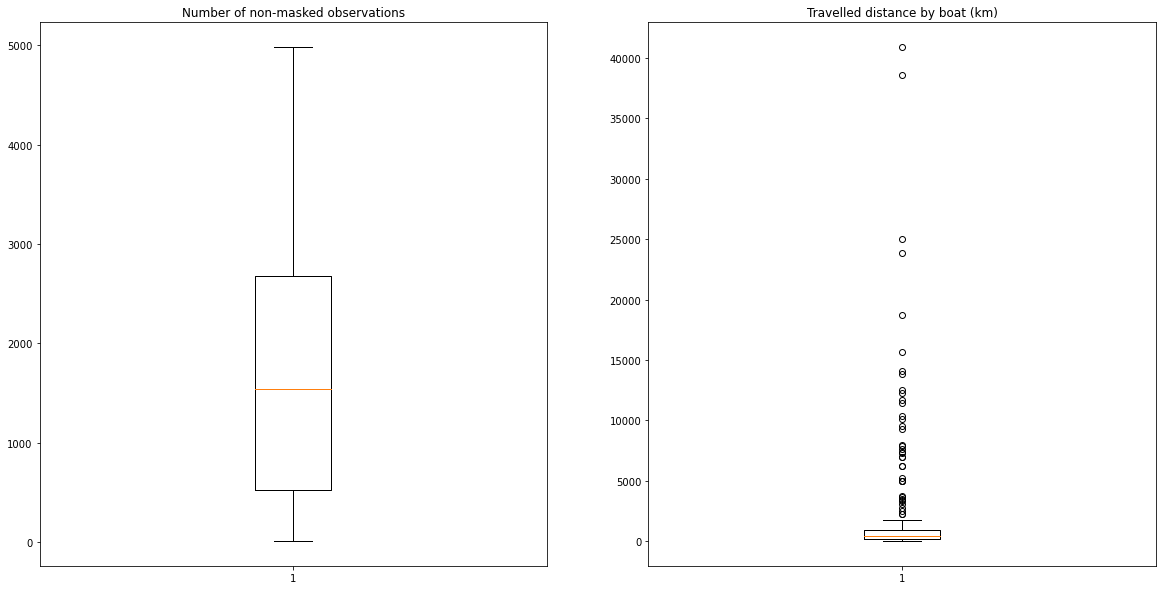

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].boxplot(non_masked_values_lat_lon)
axs[0].set_title('Number of non-masked observations')
axs[1].boxplot(distance_array)
axs[1].set_title('Travelled distance by boat (km)')

### Dataset generation

In [22]:
import pandas as pd
from datetime import datetime

In [23]:
df_complete = pd.DataFrame(columns=['mmsi', 'lat', 'lon', 'cog', 'sog', 'trh', 'time', 
                           'formatted_time', 'formatted_date', 'seq_number', 'observation_id'])

for id_boat in tqdm(range(len(lat.data))):
    lat_aux = lat[id_boat].data[~(lat[id_boat].data == lat.fill_value)]
    lon_aux = lon[id_boat].data[~(lon[id_boat].data == lon.fill_value)]
    cog_aux = cog[id_boat].data[~(cog[id_boat].data == cog.fill_value)]
    sog_aux = sog[id_boat].data[~(sog[id_boat].data == sog.fill_value)]
    trh_aux = trh[id_boat].data[~(trh[id_boat].data == trh.fill_value)]
    time_aux = time[id_boat].data[~(time[id_boat].data == time.fill_value)]
    
    if (len(lat_aux) == len(lon_aux) == len(cog_aux) == len(sog_aux) == len(trh_aux) == len(time_aux)):
        
        lat_lon = list(zip(np.array(lat[id_boat].data[~lat[id_boat].mask]), np.array(lon[id_boat].data[~lon[id_boat].mask])))
        lat_lon_cp = lat_lon.copy()

        lat_lon.pop()
        lat_lon_cp.pop(0)
        
        data = {'mmsi': str(int(mmsi[id_boat])),
            'boat_type': str(int(type_boat[id_boat])),
            'lat': lat_aux,
            'lon': lon_aux,
            'cog': cog_aux,
            'sog': sog_aux,
            'trh': trh_aux,
            'time': time_aux} 

        df = pd.DataFrame(data) 
        df['formatted_time'] = df.time.apply(lambda x: datetime.fromtimestamp(int(x)).time().isoformat())
        df['formatted_date'] = df.time.apply(lambda x: datetime.fromtimestamp(int(x)).date().isoformat())
        df['observation_id'] = id_boat
        
        ## Should we order by date?
        df_index = df.index.copy()
        df.sort_values('time', ascending=True, inplace=True)
        
        df['time_diff'] = df.time.diff()
        df['seq_number'] = df_index
        
        df_complete = df_complete.append(df, ignore_index=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:03<00:00, 47.85it/s]


We create an intermediate csv file to avoid running the previous cells every time we try to use a new model

In [ ]:
# df_complete.to_csv('EXE_20200101_000000_86400_afs_pos_formated_dynamic_var.csv', index = False)

### CSV reading

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import numpy as np

In [3]:
df_complete = pd.read_csv('EXE_20200101_000000_86400_afs_pos_formated_dynamic_var.csv')

In [4]:
df_complete.describe()

,mmsi,lat,lon,cog,sog,trh,time,seq_number,observation_id,boat_type,time_diff
count,2.755730e+05,275573.000000,275573.000000,275573.000000,275573.000000,275573.000000,2.755730e+05,275573.000000,275573.000000,275573.000000,275423.000000
mean,4.507978e+08,-34.192716,26.389741,165.979400,11.240724,163.246011,1.577881e+09,1303.810544,88.289274,66.742714,31.701132
std,1.409252e+08,1.060282,2.556329,88.723642,4.050638,89.486787,2.536815e+04,964.553080,51.041108,10.788695,100.343983
min,2.106240e+08,-36.999995,22.000000,0.000000,0.000000,0.000000,1.577837e+09,0.000000,0.000000,30.000000,0.000000
25%,3.517460e+08,-34.795700,24.249617,77.400002,9.400000,75.000000,1.577857e+09,493.000000,44.000000,70.000000,6.000000
50%,4.773277e+08,-34.429092,26.241595,211.699997,11.800000,179.000000,1.577883e+09,1132.000000,93.000000,70.000000,14.000000
75%,5.648030e+08,-33.767692,28.511067,251.699997,14.100000,252.000000,1.577903e+09,1940.000000,128.000000,70.000000,35.000000
max,6.593990e+08,-30.001977,30.999992,359.899994,36.500000,388.000000,1.577923e+09,4959.000000,175.000000,70.000000,27504.000000


The following two graphs show the distribution of the variables in the csv file.

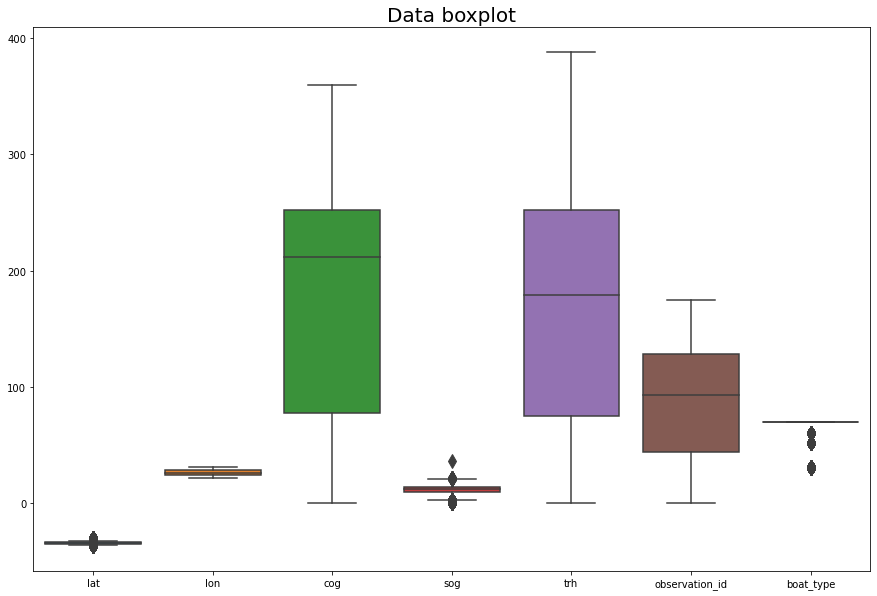

In [5]:
plt.figure(figsize=(15, 10))
plt.title('Data boxplot', fontsize=20)
food_box=sns.boxplot(data=df_complete.drop(['mmsi', 'time', 'time_diff', 'seq_number'], axis=1),fliersize=10) # fliersize is the size used to indicate the outliers
plt.show()

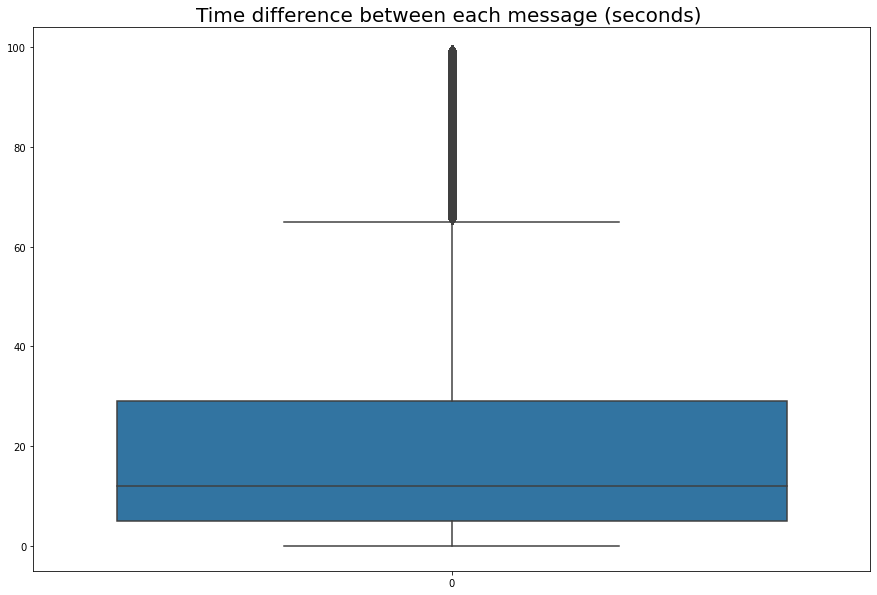

In [11]:
plt.figure(figsize=(15, 10))
plt.title("Time difference between each message (seconds) ", fontsize=20)
food_box=sns.boxplot(data=np.array(df_complete[df_complete.time_diff < 100]['time_diff']), fliersize=10) # fliersize is the size used to indicate the outliers
plt.show()

The next plot displays the distribution of classes of the data. Our data has unbalanced classes.

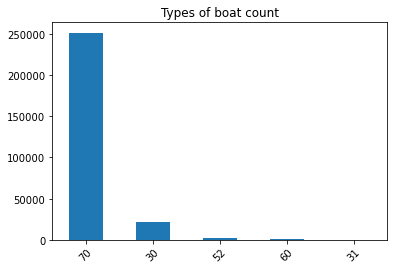

In [30]:
df_complete.boat_type.value_counts().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.title('Types of boat count')
plt.show()

### Preprocessing

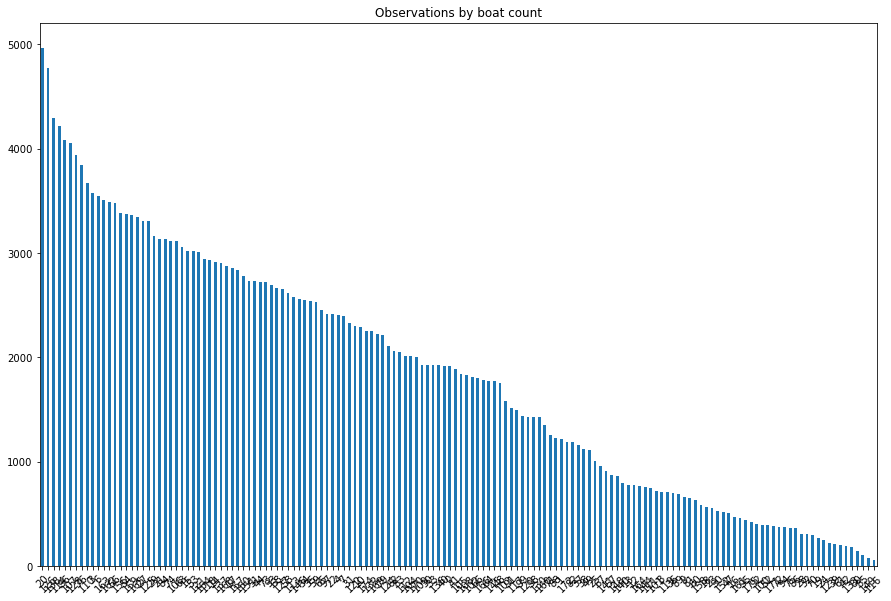

In [31]:
# The number of observations is different by each boat 
df_complete.observation_id.value_counts().plot(kind = 'bar', figsize=(15, 10))
plt.xticks(rotation = 45)
plt.title('Observations by boat count')
plt.show()

From the plot above we can see that the number of observations is different by each boat. In order to implement any ml model we need to extract same size samples from the data.

#### Time series analysis

Due to the quality of the data, for the first classification model, we will reduce the scope of the problem:

- Due to the fact that the classes are extremely unbalanced, for the moment we are only going to use classes 70 and 30.
- Since time intervals are very different, we will use only those that are in a specific range. This is because deep learning models expect the distance between each observation to be as identical as possible.
- There are messages that have the same broadcasting time. These messages will be deleted. 

In [12]:
df_3070 = df_complete[(df_complete.boat_type == 70) | (df_complete.boat_type == 30)].copy()
df_3070.dropna(inplace=True)
df_3070.head()

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff
1,210624000,-34.899330,23.988717,61.799999,2.4,60.0,1.577837e+09,01:01:37,2020-01-01,1,0,70,60.0
2,210624000,-34.899010,23.989432,62.500000,2.6,62.0,1.577837e+09,01:02:36,2020-01-01,2,0,70,59.0
3,210624000,-34.898960,23.989558,67.599998,2.5,60.0,1.577837e+09,01:02:47,2020-01-01,3,0,70,11.0
4,210624000,-34.898923,23.989685,68.699997,2.7,59.0,1.577837e+09,01:02:55,2020-01-01,4,0,70,8.0
5,210624000,-34.898628,23.990288,59.599998,2.4,60.0,1.577837e+09,01:03:46,2020-01-01,5,0,70,51.0


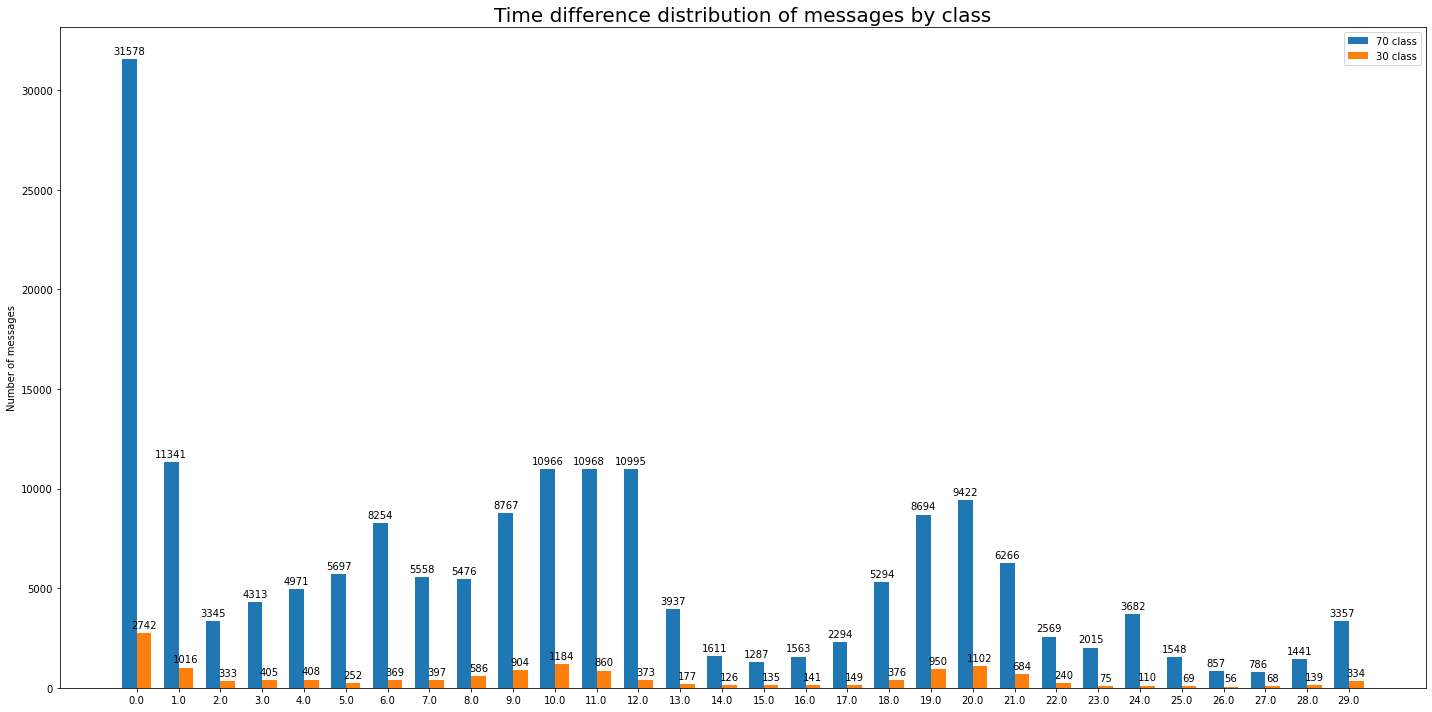

In [20]:
labels = df_3070[(df_3070.time_diff < 30)].time_diff.value_counts().sort_index().index
#class_total = df_3070[(df_3070.time_diff < 30)].time_diff.value_counts().sort_index()
class_70 = df_3070[(df_3070.time_diff < 30) & (df_3070.boat_type == 70)].time_diff.value_counts().sort_index()
class_30 = df_3070[(df_3070.time_diff < 30) & (df_3070.boat_type == 30)].time_diff.value_counts().sort_index()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, class_70, width, label='70 class')
rects2 = ax.bar(x + width/2, class_30, width, label='30 class')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of messages')
ax.set_title('Time difference distribution of messages by class', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

The graph above shows the time difference distribution of messages by class. The first thing we see is that there is a large number of messages with time difference equal to zero. The second thing is that there are many messages between the intervals of 9 to 12 seconds and 19 to 21 seconds. 

In [21]:
df_3070 = df_3070[df_3070.time_diff != 0]

In [29]:
def plot_time_diff(obs_id):
    tmp = df_3070[df_3070.observation_id == obs_id]
    #plt.figure(figsize=(20,5))
    #plt.plot(tmp.seq_number, tmp.time_diff, color='blue')
    #plt.gca().set(title='Time diff by boat ' + str(obs_id), xlabel='time', ylabel="Time diff (sec)")
    #plt.show()
    return tmp.seq_number, tmp.time_diff

In [35]:
df_3070[df_3070.boat_type == 30].observation_id.unique() # Class 30 observations

array([ 16,  17,  21,  33,  83,  84, 116, 156, 161, 165, 175])

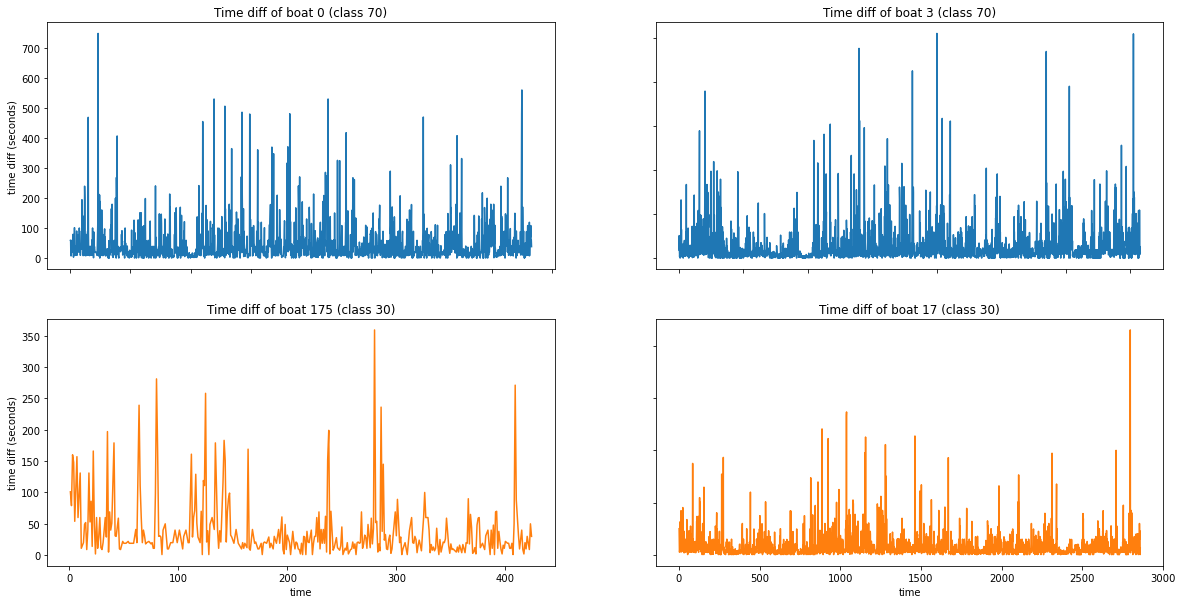

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

x, y = plot_time_diff(0)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Time diff of boat 0 (class 70)')

x, y = plot_time_diff(3)
axs[0, 1].plot(x, y)
axs[0, 1].set_title('Time diff of boat 3 (class 70)')

x, y = plot_time_diff(175)
axs[1, 0].plot(x, y, 'tab:orange')
axs[1, 0].set_title('Time diff of boat 175 (class 30)')

x, y = plot_time_diff(17)
axs[1, 1].plot(x, y, 'tab:orange')
axs[1, 1].set_title('Time diff of boat 17 (class 30)')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='time diff (seconds)')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

What you see in the above graph is the difference in seconds between each message per pot. There are sections of the graph where the interval between messages is relatively low, however there are parts where the interval is very high.

In [175]:
obs_ids = np.array(df_3070.observation_id.values)
time_diff = np.array(df_3070.time_diff.values)
new_obs_ids = obs_ids.copy()

In [211]:
def get_segments_index(obs_ids, time_diff, new_obs_ids,
                      wrong_value = -99, min_interval = 8,
                       max_interval = 13, seq_size = 10):
    i = 0

    counter = 0
    new_id = 0

    while i < len(obs_ids):
        if counter == seq_size:
            counter = 0
            new_id += 1

        if time_diff[i] > max_interval:
            counter = 0
            new_id += 1
            new_obs_ids[i] = wrong_value
            
        elif ((time_diff[i] <= max_interval) & (time_diff[i] >= min_interval)):
            new_obs_ids[i] = new_id
            
            if (new_obs_ids[i-1] == wrong_value):
                new_obs_ids[i-1] = new_id
                counter += 1
            counter += 1
             
        else:
            #if ((time_diff[i] + time_diff[i+1] <= max_interval) & (time_diff[i] + time_diff[i+1]  >= min_interval)):
            #    new_obs_ids[i] = wrong_value
            #    new_obs_ids[i+1] = new_id
                
            #    if (new_obs_ids[i-1] == wrong_value):
            #        new_obs_ids[i-1] = new_id
            #        counter += 1
               
            #    counter += 1
            #else:
            #    counter = 0
            #    new_id += 1    
            #    new_obs_ids[i] = wrong_value  
                
            counter = 0
            new_id += 1    
            new_obs_ids[i] = wrong_value  
        i += 1   
    return(new_obs_ids)

In [212]:
n_segments_30 = []
n_segments_70 = []
min_segment = 2
max_segment = 20

for j in tqdm(range(min_segment, max_segment)):
    res = get_segments_index(obs_ids, time_diff, new_obs_ids, seq_size = j)
    df_3070['new_observation_id'] = res
    df_seq = df_3070.groupby('new_observation_id').filter(lambda x: len(x) == j)
    aux = df_seq.boat_type.value_counts()
    if (len(aux) == 2):
        n_segments_30.append(aux.values[1]/j)
        n_segments_70.append(aux.values[0]/j)
    elif (len(aux) == 1):
        n_segments_30.append(0)
        n_segments_70.append(aux.values[0]/j)
    else:
        n_segments_30.append(0)
        n_segments_70.append(0)  

100%|███████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]


The idea behind the above two cells is to look for segments in the time series where the intervals between messages are as constant as possible. For this first experiment we are going to look for messages with an interval between 8 and 13 seconds.

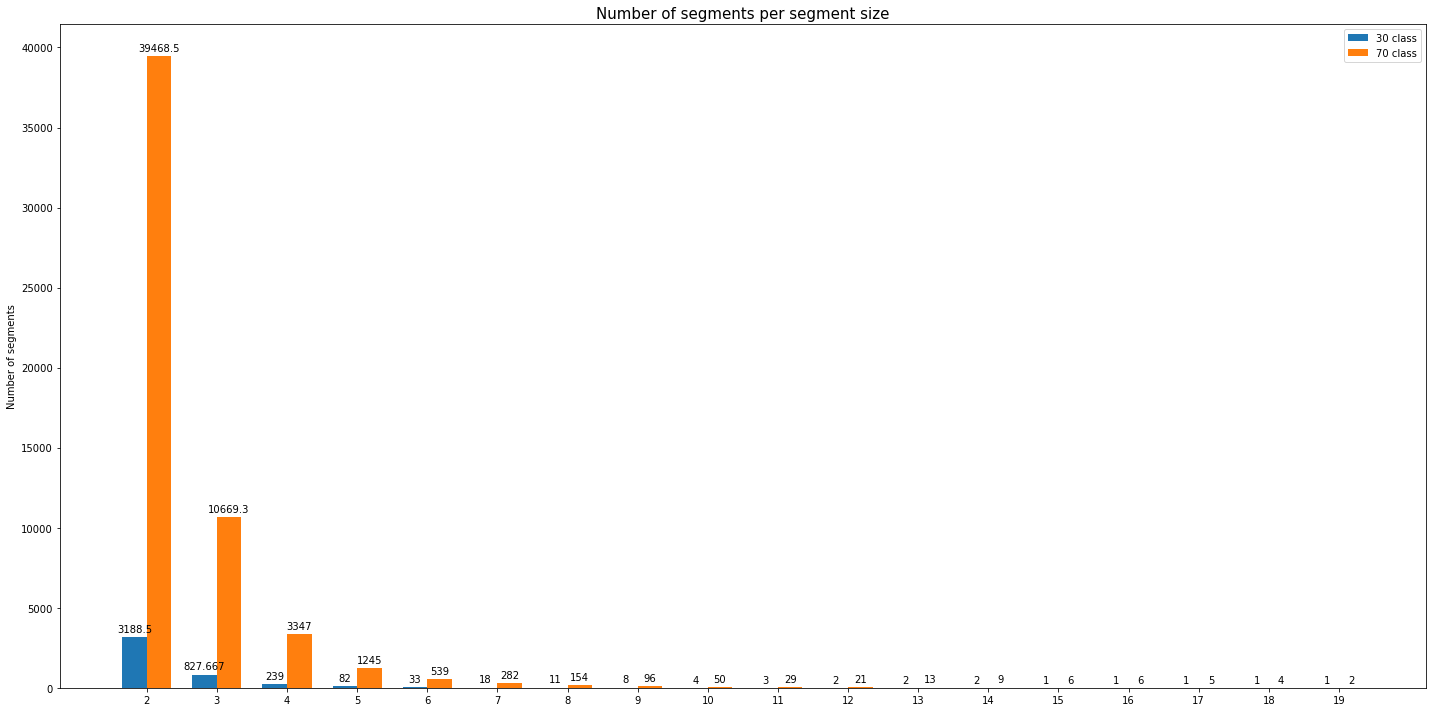

In [213]:
labels = range(min_segment, max_segment)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, n_segments_30, width, label='30 class')
rects2 = ax.bar(x + width/2, n_segments_70, width, label='70 class')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of segments')
ax.set_title('Number of segments per segment size', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

The graph above shows the number of segments that exist as a function of segment size. For example, class 70 has 1245 segments of 5 messages with an interval between them of 8 to 13 seconds.

### Time series classification with pytorch

For the first classification model we will use a multivariate LSTM. The length of the time series will be 4.

#### With seq_size = 4

In [ ]:
#!pip install tensorflow
#!pip install pytorch-lightning

In [205]:
import tensorflow as tf
tf.config.experimental.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [206]:
import random

In [207]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [208]:
pl.seed_everything(42)

Global seed set to 42


42

In [279]:
res = get_segments_index(obs_ids, time_diff, new_obs_ids, seq_size = 4)
df_3070['new_observation_id'] = res
df_8 = df_3070.groupby('new_observation_id').filter(lambda x: len(x) == 4).copy()

In [311]:
df_8.head(4)

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff,new_observation_id
343,210624000,-35.035785,23.965157,212.699997,2.9,210.0,1.577852e+09,05:18:45,2020-01-01,343,0,70,20.0,257
344,210624000,-35.035912,23.965078,210.100006,2.7,211.0,1.577852e+09,05:18:56,2020-01-01,344,0,70,11.0,257
345,210624000,-35.036033,23.965002,207.699997,2.9,211.0,1.577852e+09,05:19:05,2020-01-01,345,0,70,9.0,257
346,210624000,-35.036170,23.964908,208.000000,3.1,211.0,1.577852e+09,05:19:16,2020-01-01,346,0,70,11.0,257


In the table above we can see a segment of 4 messages with an interval between 8 and 13 seconds.

### Preprocessing

Due to the unbalanced classes, we will take all the observations of class 30 and only part of the observations of class 70. 

In [281]:
sample_id_30 = df_8[df_8.boat_type == 30].new_observation_id.unique()
sample_id_70 = random.sample(sorted(df_8[df_8.boat_type == 70].new_observation_id.unique()), 239*2)

In [282]:
len(sample_id_30)

239

In [283]:
len(sample_id_70)

478

In [284]:
balanced_sample = df_8[(df_8.new_observation_id.isin(sample_id_30)) | (df_8.new_observation_id.isin(sample_id_70))].copy()

In [344]:
balanced_sample.shape[0]/4

717.0

In [286]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(balanced_sample.boat_type) 

In [287]:
encoded_labels[:5]

array([1, 1, 1, 1, 1])

In [288]:
label_encoder.classes_

array([30, 70])

In [289]:
balanced_sample["label"] = encoded_labels

In [345]:
balanced_sample.head()

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff,new_observation_id,label
485,210624000,-35.090608,23.925343,216.199997,3.0,216.0,1.577857e+09,06:41:53,2020-01-01,485,0,70,38.0,357,1
486,210624000,-35.090727,23.925272,204.500000,3.1,216.0,1.577857e+09,06:42:02,2020-01-01,486,0,70,9.0,357,1
487,210624000,-35.090853,23.925188,207.500000,3.1,216.0,1.577857e+09,06:42:12,2020-01-01,487,0,70,10.0,357,1
488,210624000,-35.090980,23.925097,207.500000,3.0,215.0,1.577857e+09,06:42:23,2020-01-01,488,0,70,11.0,357,1
1204,210624000,-34.960928,23.998630,6.500000,0.7,57.0,1.577892e+09,16:26:36,2020-01-01,1204,0,70,30.0,899,1


In [290]:
FEATURE_COLUMNS = ['lat', 'lon', 'cog', 'sog', 'trh']
FEATURE_COLUMNS

['lat', 'lon', 'cog', 'sog', 'trh']

In [291]:
sequences = []

for series_id, group in balanced_sample.groupby("new_observation_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = balanced_sample[balanced_sample.new_observation_id == series_id].iloc[0].label
    
    sequences.append((sequence_features, label))

In [292]:
sequences[0][0].dtypes

lat    float64
lon    float64
cog    float64
sog    float64
trh    float64
dtype: object

In [293]:
train_sequences, test_sequences = train_test_split(sequences, test_size = 0.2)

In [294]:
len(train_sequences) + len(test_sequences)

717

In [322]:
class BoatDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).long()
        )

In [323]:
class BoatDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = BoatDataset(self.train_sequences)
        self.test_dataset = BoatDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
        

In [324]:
N_EPOCHS = 300
BATCH_SIZE = 1000

data_module = BoatDataModule(train_sequences, test_sequences, BATCH_SIZE)

In [325]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.classifier(out)

In [326]:
class BoatPredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [327]:
model = BoatPredictor(
    n_features=len(FEATURE_COLUMNS), 
    n_classes=2)

In [328]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [329]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="var_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="surface")

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    progress_bar_refresh_rate=0
)

/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f6edcfbcd90>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f6edcfbcd90>)`.
  rank_zero_deprecation(
/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(


In [330]:
trainer.fit(model, data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.290     Total estimated model params size (MB)
Global seed set to 42
/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


In [331]:
trainer.test(dataloaders=data_module)

/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1391: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at lightning_logs/surface/version_25/checkpoints/epoch=299-step=299.ckpt
Loaded model weights from checkpoint at lightning_logs/surface/version_25/checkpoints/epoch=299-step=299.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8263888955116272, 'test_loss': 0.42917901277542114}
--------------------------------------------------------------------------------


[{'test_loss': 0.42917901277542114, 'test_accuracy': 0.8263888955116272}]

The train model has an accuracy of 0.82.

In the following cells we can see the misclassified observations:

In [349]:
model.freeze()

test_dataset = BoatDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]
    
    _, output = model(sequence.unsqueeze(dim = 0))
    predictions.append(torch.argmax(output, dim = 1).numpy()[0])
    labels.append(label.item())


100%|████████████████████████████████████████| 144/144 [00:00<00:00, 825.03it/s]


In [334]:
test_results = pd.DataFrame.from_dict({'predictions': predictions, 'labels': labels})
test_results.head(10)

,predictions,labels
0,0,0
1,0,0
2,1,1
3,0,0
4,0,1
5,1,1
6,0,0
7,1,1
8,0,0
9,1,1


In [348]:
test_results.shape[0]

144

In [335]:
test_results[test_results.predictions == test_results.labels].shape[0]

119

In [336]:
test_results[test_results.predictions != test_results.labels].shape[0]

25

In [339]:
errors_ = test_results[test_results.predictions != test_results.labels]
errors_

,predictions,labels
4,0,1
16,0,1
17,0,1
21,0,1
33,0,1
38,1,0
39,1,0
40,1,0
41,0,1
44,0,1


In [347]:
# Class 70
(errors_.labels == 1).sum()

15

In [346]:
# Class 30
(errors_.labels == 0).sum()

10

Other models could be explored by varying the size of the segments and their interval, reading more datasets and preprocessing them, and using data augmentation techniques. 